# La détection et classification des insectes nuisibles aux plantes du raisin

## Collecte des Images


Le jeu de données qu'on va utiliser est extrait d'apres Kaggle via le lien suivant:
<a href="https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset" target="_blank">Les Images d'insects nuisibles</a>
Le Dangerous Farm Insects Image Dataset est une collection d’images regroupant 15 espèces d’insectes couramment rencontrés dans les environnements agricoles. Conçu pour faciliter l’identification et l’analyse de ces nuisibles, le dataset offre des images de haute qualité mettant en avant les traits distinctifs, les couleurs et les motifs de chaque insecte. Avec un total de 1591 fichiers pour une taille de 474 MB, il est structuré en 15 classes d’insectes, dont certaines sont particulièrement nuisibles à la culture du raisin. Ces insectes incluent les pucerons (Aphids), les acariens rouges (Spider Mites), les thrips (Thrips), les mouches des fruits (Fruit Flies), et les punaises diaboliques (Brown Marmorated Stink Bugs), qui causent des dommages directs à la vigne. Par ailleurs, des espèces comme les chenilles légionnaires (Fall Armyworms) et les sphinx de la tomate (Tomato Hornworms) peuvent affecter indirectement la vigne en perturbant les cultures environnantes. Ce dataset, divisé en 1428 images pour l’entraînement et 357 pour le test, sera utilisé pour développer un modèle de détection ciblant spécifiquement les insectes nuisibles aux raisins.

In [1]:
!pip install -U -q evaluate transformers datasets>=2.14.5 mlflow 2>/dev/null

In [2]:
import warnings 
warnings.filterwarnings("ignore") 
import gc 
import numpy as np 
import pandas as pd
import itertools 
from collections import Counter 
import matplotlib.pyplot as plt
from sklearn.metrics import ( 
    accuracy_score,
    roc_auc_score, 
    confusion_matrix, 
    classification_report, 
    f1_score ,
    recall_score
)
from imblearn.over_sampling import RandomOverSampler
import evaluate 
from datasets import Dataset, Image, ClassLabel  
from transformers import ( 
    TrainingArguments,  
    Trainer, 
    ViTImageProcessor,  
    ViTForImageClassification,  
    DefaultDataCollator 
)
import torch 
from torch.utils.data import DataLoader  
from torchvision.transforms import (  
    CenterCrop, 
    Compose,  
    Normalize,  
    RandomRotation, 
    RandomResizedCrop,  
    RandomHorizontalFlip,  
    RandomAdjustSharpness, 
    Resize,
    ToTensor  
)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
from tqdm import tqdm
import os
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0 , Xception
from transformers import BasicTokenizer
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
image_dict = {}
file_names = []
labels = []
for file in tqdm(sorted((Path('/kaggle/input/dangerous-insects-dataset/farm_insects/').glob('*/*.*')))):
    label = str(file).split('/')[-2]  
    labels.append(label)  
    file_names.append(str(file)) 
print(len(file_names), len(labels))

100%|██████████| 1591/1591 [00:00<00:00, 212750.67it/s]

1591 1591


In [4]:
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

(1591, 2)


In [5]:
df.head()

,image,label
0,/kaggle/input/dangerous-insects-dataset/farm_i...,Africanized Honey Bees (Killer Bees)
1,/kaggle/input/dangerous-insects-dataset/farm_i...,Africanized Honey Bees (Killer Bees)
2,/kaggle/input/dangerous-insects-dataset/farm_i...,Africanized Honey Bees (Killer Bees)
3,/kaggle/input/dangerous-insects-dataset/farm_i...,Africanized Honey Bees (Killer Bees)
4,/kaggle/input/dangerous-insects-dataset/farm_i...,Africanized Honey Bees (Killer Bees)


## Image Processing and oversampling techniques

In [6]:
df['label'].unique()

array(['Africanized Honey Bees (Killer Bees)', 'Aphids', 'Armyworms',
       'Brown Marmorated Stink Bugs', 'Cabbage Loopers', 'Citrus Canker',
       'Colorado Potato Beetles', 'Corn Borers', 'Corn Earworms',
       'Fall Armyworms', 'Fruit Flies', 'Spider Mites', 'Thrips',
       'Tomato Hornworms', 'Western Corn Rootworms'], dtype=object)

In [7]:
y = df[['label']]
df = df.drop(['label'], axis=1)

In [8]:
ros = RandomOverSampler(random_state=83)

In [9]:
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()
print(df.shape)

(1785, 2)


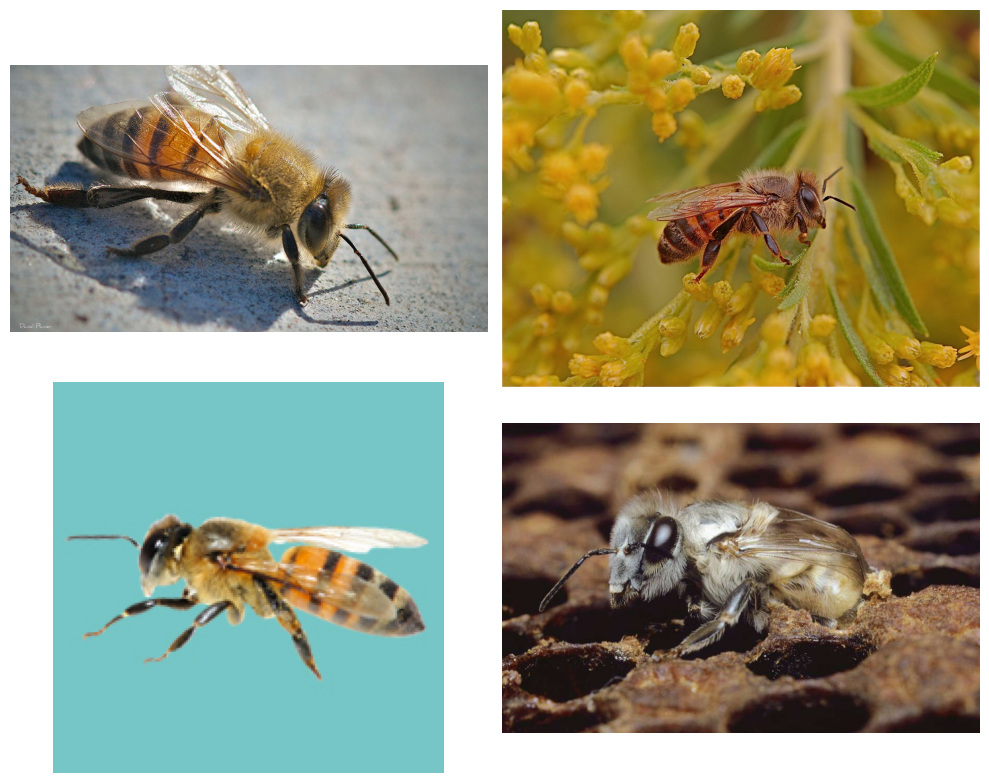

In [10]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i in range(4):
    image = dataset[i]["image"]
    axes[i // 2, i % 2].imshow(image)
    axes[i // 2, i % 2].axis("off")
plt.tight_layout()
plt.show()

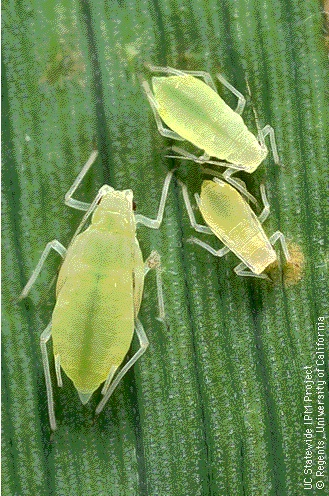

In [11]:
dataset[100]["image"]

In [12]:
labels_subset = labels[:5]
print(labels_subset)

['Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)', 'Africanized Honey Bees (Killer Bees)']


In [13]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i 
    id2label[i] = label  
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Corn Borers', 1: 'Thrips', 2: 'Western Corn Rootworms', 3: 'Colorado Potato Beetles', 4: 'Corn Earworms', 5: 'Fall Armyworms', 6: 'Armyworms', 7: 'Citrus Canker', 8: 'Tomato Hornworms', 9: 'Brown Marmorated Stink Bugs', 10: 'Fruit Flies', 11: 'Aphids', 12: 'Africanized Honey Bees (Killer Bees)', 13: 'Spider Mites', 14: 'Cabbage Loopers'} 

Mapping of Labels to IDs: {'Corn Borers': 0, 'Thrips': 1, 'Western Corn Rootworms': 2, 'Colorado Potato Beetles': 3, 'Corn Earworms': 4, 'Fall Armyworms': 5, 'Armyworms': 6, 'Citrus Canker': 7, 'Tomato Hornworms': 8, 'Brown Marmorated Stink Bugs': 9, 'Fruit Flies': 10, 'Aphids': 11, 'Africanized Honey Bees (Killer Bees)': 12, 'Spider Mites': 13, 'Cabbage Loopers': 14}


In [14]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/1785 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1785 [00:00<?, ? examples/s]

In [15]:
train_data.shape,test_data.shape

((1428, 2), (357, 2))

In [16]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 1428
})

## Construction des modèles

Dans ce notebook, on travaillera sur les modèles suivants :
<ul>
    <li>ViT</li> 
    <li>MobileNet</li>   
    <li>ResNet</li> 
    <li>EffecientNet</li> 
    <li>Xception</li> 
</ul>

### ViT
ou Vision Transformer, qui est une architecture de réseau de neurones profonds conçue spécifiquement pour les tâches de vision par ordinateur, telles que la classification d'images.

In [17]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


### Normalisation des images

In [18]:
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        Resize((size, size)),             # Redimensionner les images à la taille d'entrée du modèle ViT
        RandomRotation(90),               # Appliquer une rotation aléatoire
        RandomAdjustSharpness(2),         # Ajuster la netteté de manière aléatoire
        ToTensor(),                       # Convertir les images en tensors
        normalize                         # Normaliser les images en utilisant la moyenne et l'écart type
    ]
)
_val_transforms = Compose(
    [
        Resize((size, size)),             # Redimensionner les images à la taille d'entrée du modèle ViT
        ToTensor(),                       # Convertir les images en tensors
        normalize                         # Normaliser les images en utilisant la moyenne et l'écart type
    ]
)

### Créer la fonction de transformation sur l'ensemble d'entrainement et l'ensemble de test

In [19]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [20]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [21]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

### La construction de modèle et affichage de nombre de paramètres qui doivent être entrainés

In [22]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.810191


### Créer la fonction de calcul des métriques

In [23]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }

### Entrainement du modèle

In [24]:
metric_name = "accuracy"
model_name = "farm_insects_image_detection"
num_train_epochs = 50
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=64,   
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,    
    weight_decay=0.02,
    warmup_steps=50,    
    remove_unused_columns=False,  
    save_strategy='epoch',   
    load_best_model_at_end=True,    
    save_total_limit=1,    
    report_to="mlflow"  
)

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.711566,0.070028
2,No log,2.695530,0.103641
3,No log,2.668495,0.128852
4,No log,2.629322,0.243697
5,No log,2.577976,0.406162
6,No log,2.522664,0.512605
7,No log,2.465651,0.596639
8,No log,2.407598,0.638655
9,No log,2.349346,0.677871
10,No log,2.287477,0.714286


TrainOutput(global_step=600, training_loss=1.6711431630452473, metrics={'train_runtime': 3170.7512, 'train_samples_per_second': 22.518, 'train_steps_per_second': 0.189, 'total_flos': 5.533572726975283e+18, 'train_loss': 1.6711431630452473, 'epoch': 50.0})

In [27]:
trainer.evaluate()

{'eval_loss': 1.3925418853759766,
 'eval_accuracy': 0.8123249299719888,
 'eval_runtime': 8.815,
 'eval_samples_per_second': 40.499,
 'eval_steps_per_second': 0.681,
 'epoch': 50.0}

ce modèle montre des performances satisfaisantes avec une précision de 81,23%, signifiant qu'il identifie correctement plus de quatre insectes sur cinq. Bien que ce score soit encourageant pour une tâche de classification potentiellement complexe, la perte d'évaluation relativement élevée (1,39) suggère qu'il existe une marge d'amélioration. L'entraînement sur 50 époques, combiné à un temps d'exécution raisonnable de 8,8 secondes et un taux de traitement de 40,5 échantillons par seconde, indique un modèle fonctionnel et stable, mais qui pourrait potentiellement bénéficier d'optimisations supplémentaires pour améliorer sa confiance dans les prédictions.

In [28]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 1.3925418853759766, 'test_accuracy': 0.8123249299719888, 'test_runtime': 8.6959, 'test_samples_per_second': 41.054, 'test_steps_per_second': 0.69}


In [29]:
trainer.save_model("/kaggle/working/")

## Transfer learning : MobileNet , EffecientNet , ResNet , Xception

### Définir les hypérparamètres 

In [30]:
input_shape = (224, 224, 3) 
num_classes = len(labels_list)
batch_size = 32

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, shuffle=True, random_state=42)

### Augmentation des données

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image': X_train, 'label': y_train}),
    x_col="image",
    y_col="label",
    class_mode="sparse",  
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

Found 1418 validated image filenames belonging to 15 classes.


In [34]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image': X_test, 'label': y_test}),
    x_col="image",
    y_col="label",
    class_mode="sparse",
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False
)

Found 354 validated image filenames belonging to 15 classes.


### MobileNet

In [35]:
def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
mobilenet_model = create_mobilenet_model(input_shape, num_classes)

9406464/9406464 [==============================] - 0s 0us/step


In [36]:
mobilenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=50, 
    validation_data=test_generator
)

Epoch 1/50
45/45 [==============================] - 43s 850ms/step - loss: 2.1276 - accuracy: 0.3484 - val_loss: 1.5033 - val_accuracy: 0.5226
Epoch 2/50
45/45 [==============================] - 37s 826ms/step - loss: 1.2286 - accuracy: 0.6354 - val_loss: 1.2282 - val_accuracy: 0.5989
Epoch 3/50
45/45 [==============================] - 37s 813ms/step - loss: 0.9591 - accuracy: 0.7278 - val_loss: 1.0922 - val_accuracy: 0.6667
Epoch 4/50
45/45 [==============================] - 36s 801ms/step - loss: 0.8161 - accuracy: 0.7567 - val_loss: 1.0490 - val_accuracy: 0.6667
Epoch 5/50
45/45 [==============================] - 36s 795ms/step - loss: 0.7379 - accuracy: 0.7856 - val_loss: 1.0238 - val_accuracy: 0.6921
Epoch 6/50
45/45 [==============================] - 36s 802ms/step - loss: 0.6346 - accuracy: 0.8244 - val_loss: 0.9658 - val_accuracy: 0.7090
Epoch 7/50
45/45 [==============================] - 36s 799ms/step - loss: 0.5622 - accuracy: 0.8420 - val_loss: 0.9648 - val_accuracy: 0.7175

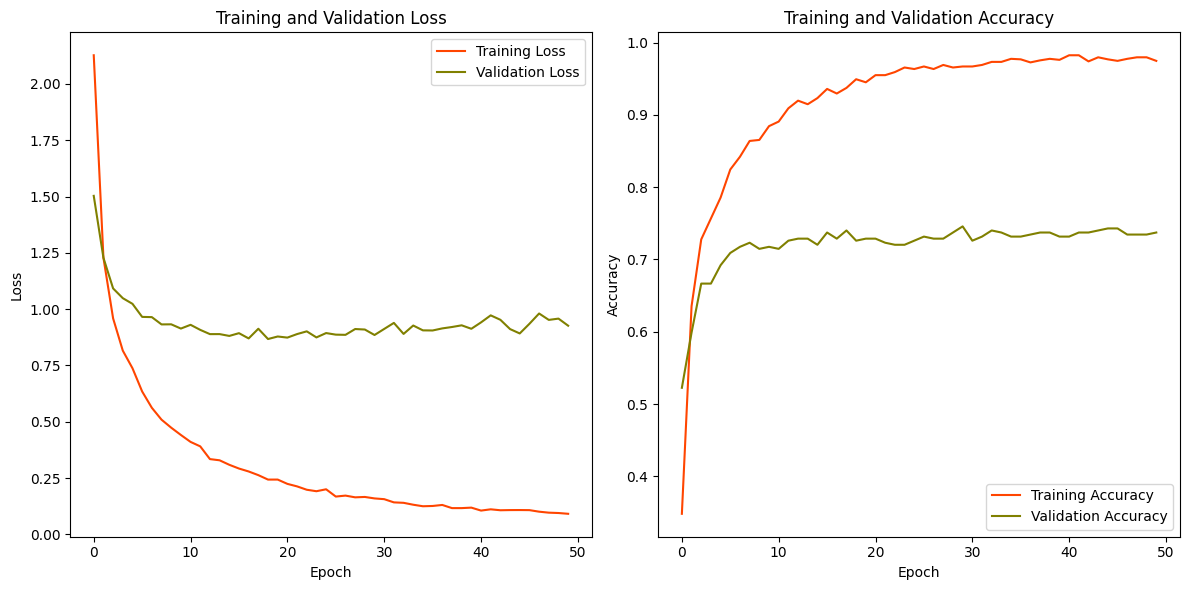

In [38]:
train_loss = history_mobilenet.history['loss']
train_acc = history_mobilenet.history['accuracy']
val_loss = history_mobilenet.history['val_loss']
val_acc = history_mobilenet.history['val_accuracy']

# Plot des variations de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss',color='orangered')
plt.plot(val_loss, label='Validation Loss',color='olive')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot des variations d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy',color='orangered')
plt.plot(val_acc, label='Validation Accuracy',color='olive')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

### ResNet

In [39]:
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(
        include_top=False,
        input_shape=input_shape,
        weights='imagenet'
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
resnet_model = create_resnet_model(input_shape, num_classes)

94765736/94765736 [==============================] - 0s 0us/step


In [40]:
# Compiler les modèles
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
history_resnet = resnet_model.fit(
    train_generator,
    epochs=50, 
    validation_data=test_generator
)

Epoch 1/50
45/45 [==============================] - 42s 830ms/step - loss: 2.7602 - accuracy: 0.0769 - val_loss: 2.7070 - val_accuracy: 0.0621
Epoch 2/50
45/45 [==============================] - 36s 809ms/step - loss: 2.7110 - accuracy: 0.0748 - val_loss: 2.6927 - val_accuracy: 0.0565
Epoch 3/50
45/45 [==============================] - 36s 797ms/step - loss: 2.6987 - accuracy: 0.0952 - val_loss: 2.6830 - val_accuracy: 0.0989
Epoch 4/50
45/45 [==============================] - 36s 798ms/step - loss: 2.6946 - accuracy: 0.0938 - val_loss: 2.7011 - val_accuracy: 0.1017
Epoch 5/50
45/45 [==============================] - 36s 802ms/step - loss: 2.6862 - accuracy: 0.1058 - val_loss: 2.6519 - val_accuracy: 0.1102
Epoch 6/50
45/45 [==============================] - 36s 806ms/step - loss: 2.6707 - accuracy: 0.1150 - val_loss: 2.6761 - val_accuracy: 0.0876
Epoch 7/50
45/45 [==============================] - 36s 797ms/step - loss: 2.6665 - accuracy: 0.1044 - val_loss: 2.6499 - val_accuracy: 0.1328

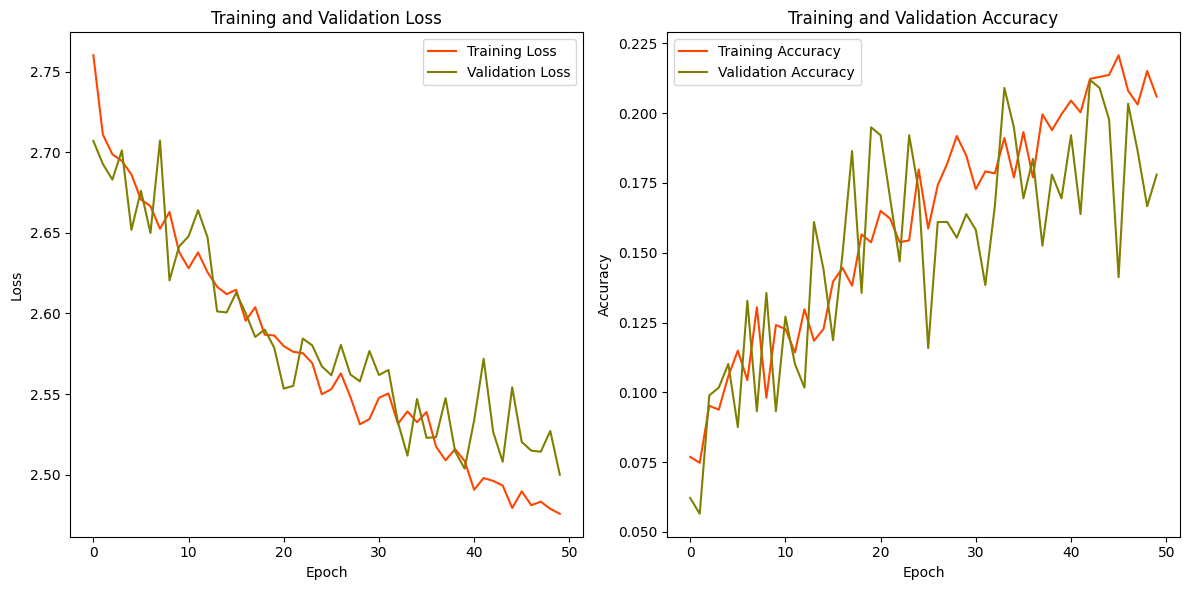

In [42]:
train_loss = history_resnet.history['loss']
train_acc = history_resnet.history['accuracy']
val_loss = history_resnet.history['val_loss']
val_acc = history_resnet.history['val_accuracy']

# Plot des variations de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss',color='orangered')
plt.plot(val_loss, label='Validation Loss',color='olive')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot des variations d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy',color='orangered')
plt.plot(val_acc, label='Validation Accuracy',color='olive')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

### EfficientNet

In [43]:
def create_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
efficientnet_model = create_efficientnet_model(input_shape, num_classes)

16705208/16705208 [==============================] - 0s 0us/step


In [44]:
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
history_efficientnet = efficientnet_model.fit(
    train_generator,
    epochs=50, 
    validation_data=test_generator
)

Epoch 1/50


2023-12-20 10:08:42.030476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 [==============================] - 45s 854ms/step - loss: 2.7597 - accuracy: 0.0698 - val_loss: 2.7804 - val_accuracy: 0.0763
Epoch 2/50
45/45 [==============================] - 36s 796ms/step - loss: 2.7347 - accuracy: 0.0614 - val_loss: 2.7649 - val_accuracy: 0.0678
Epoch 3/50
45/45 [==============================] - 36s 791ms/step - loss: 2.7439 - accuracy: 0.0628 - val_loss: 2.7433 - val_accuracy: 0.0734
Epoch 4/50
45/45 [==============================] - 36s 798ms/step - loss: 2.7423 - accuracy: 0.0663 - val_loss: 2.7352 - val_accuracy: 0.0537
Epoch 5/50
45/45 [==============================] - 36s 795ms/step - loss: 2.7396 - accuracy: 0.0621 - val_loss: 2.7377 - val_accuracy: 0.0593
Epoch 6/50
45/45 [==============================] - 36s 793ms/step - loss: 2.7423 - accuracy: 0.0550 - val_loss: 2.7567 - val_accuracy: 0.0791
Epoch 7/50
45/45 [==============================] - 36s 812ms/step - loss: 2.7423 - accuracy: 0.0649 - val_loss: 2.7529 - val_accuracy: 0.0565
Epoch 8/50

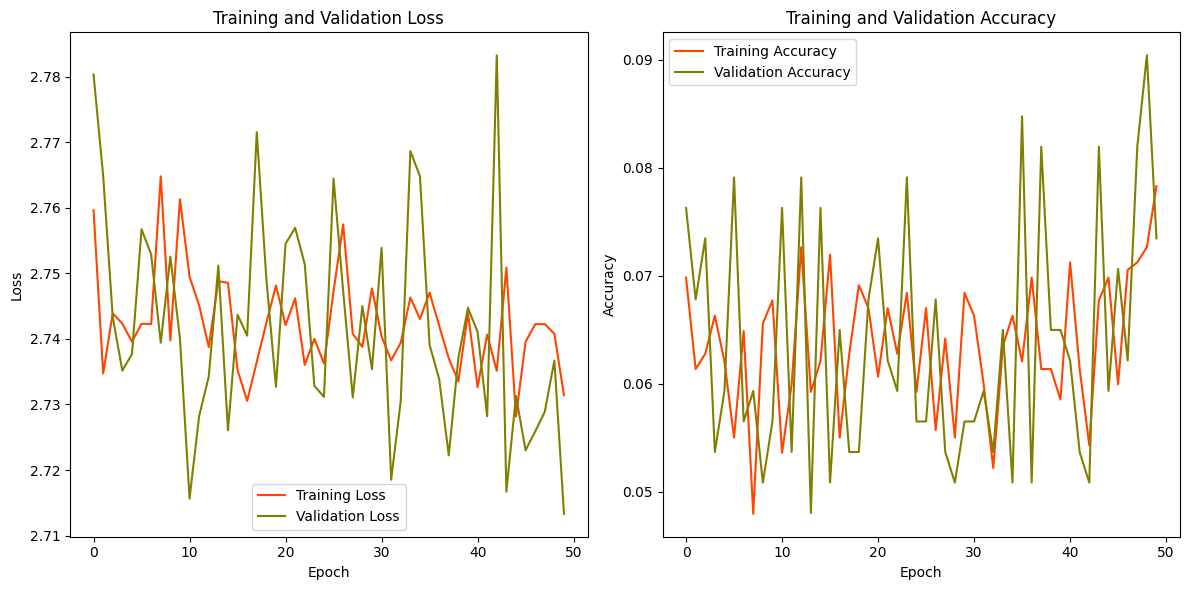

In [46]:
train_loss = history_efficientnet.history['loss']
train_acc = history_efficientnet.history['accuracy']
val_loss = history_efficientnet.history['val_loss']
val_acc = history_efficientnet.history['val_accuracy']

# Plot des variations de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss',color='orangered')
plt.plot(val_loss, label='Validation Loss',color='olive')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot des variations d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy',color='orangered')
plt.plot(val_acc, label='Validation Accuracy',color='olive')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

### Xception

In [47]:
def create_xception_model(input_shape, num_classes):
    base_model = Xception(
        include_top=False,
        input_shape=input_shape,
        weights='imagenet'
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
xception_model = create_xception_model(input_shape, num_classes)

83683744/83683744 [==============================] - 0s 0us/step


In [48]:
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
history_xception = xception_model.fit(
    train_generator,
    epochs=50, 
    validation_data=test_generator
)

Epoch 1/50
45/45 [==============================] - 41s 813ms/step - loss: 1.9920 - accuracy: 0.4217 - val_loss: 1.4205 - val_accuracy: 0.5904
Epoch 2/50
45/45 [==============================] - 36s 788ms/step - loss: 1.2581 - accuracy: 0.6382 - val_loss: 1.1706 - val_accuracy: 0.6243
Epoch 3/50
45/45 [==============================] - 36s 799ms/step - loss: 1.0239 - accuracy: 0.7165 - val_loss: 1.0360 - val_accuracy: 0.6667
Epoch 4/50
45/45 [==============================] - 36s 798ms/step - loss: 0.8966 - accuracy: 0.7546 - val_loss: 0.9656 - val_accuracy: 0.6638
Epoch 5/50
45/45 [==============================] - 36s 788ms/step - loss: 0.7958 - accuracy: 0.7757 - val_loss: 0.9315 - val_accuracy: 0.6921
Epoch 6/50
45/45 [==============================] - 36s 794ms/step - loss: 0.7258 - accuracy: 0.7955 - val_loss: 0.8911 - val_accuracy: 0.7119
Epoch 7/50
45/45 [==============================] - 36s 798ms/step - loss: 0.6628 - accuracy: 0.8110 - val_loss: 0.8762 - val_accuracy: 0.6921

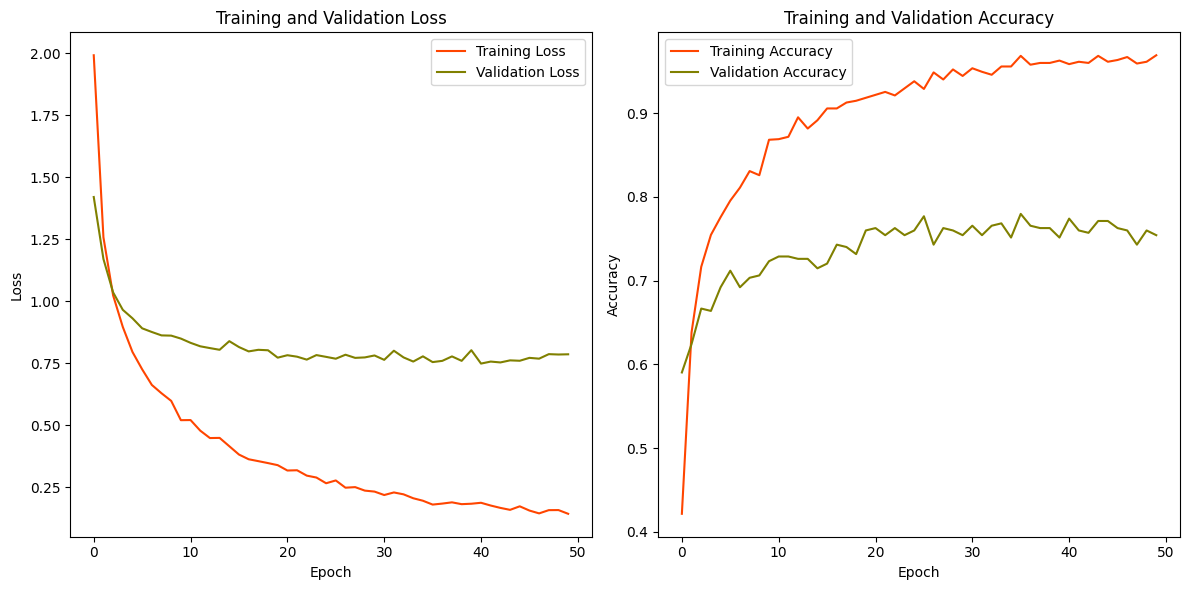

In [50]:
train_loss = history_xception.history['loss']
train_acc = history_xception.history['accuracy']
val_loss = history_xception.history['val_loss']
val_acc = history_xception.history['val_accuracy']

# Plot des variations de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss',color='orangered')
plt.plot(val_loss, label='Validation Loss',color='olive')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot des variations d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy',color='orangered')
plt.plot(val_acc, label='Validation Accuracy',color='olive')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

In [51]:
xception_model.save("/kaggle/working/")

## Evaluation des Modèles et Choix du modèle

### Créer une fonction qui permet de dessiner et visualiser les matrices de confusion

In [52]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Oranges, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### la fonction pour évaluer le modèle et afficher la matrice de confusion et le rapport de classification

In [53]:
def evaluate_model(model, test_generator, labels_list):
    predictions = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred = predictions.argmax(axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {f1:.4f}")
    if len(labels_list) <= 150:
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, labels_list, figsize=(18, 16))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

### On applique ces fonctions sur nos modèles

#### ViT

Accuracy: 0.8123
F1 Score: 0.8014


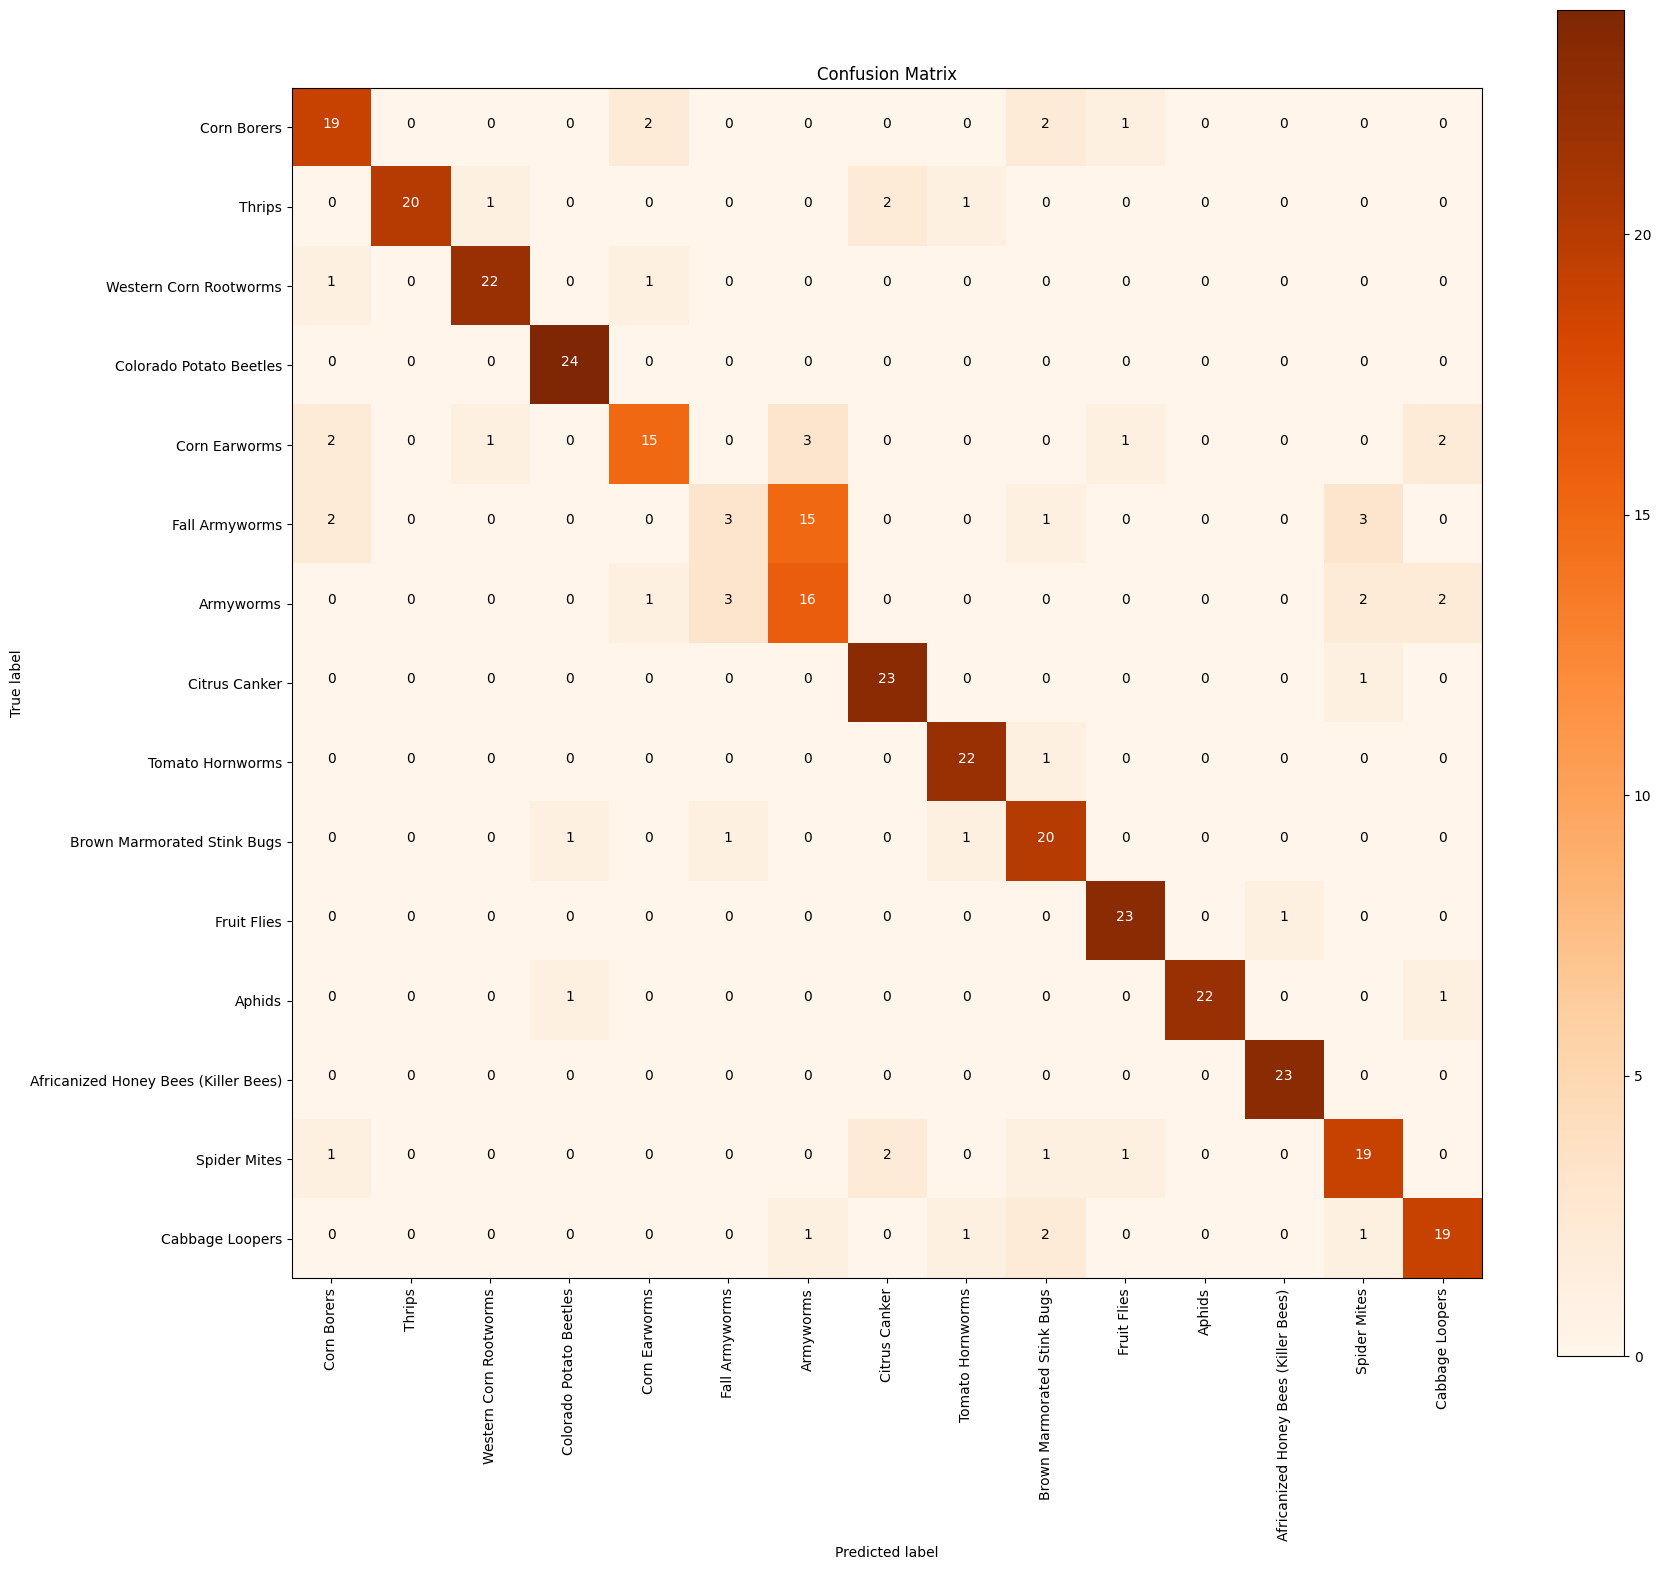


Classification report:

                                      precision    recall  f1-score   support

                         Corn Borers     0.7600    0.7917    0.7755        24
                              Thrips     1.0000    0.8333    0.9091        24
              Western Corn Rootworms     0.9167    0.9167    0.9167        24
             Colorado Potato Beetles     0.9231    1.0000    0.9600        24
                       Corn Earworms     0.7895    0.6250    0.6977        24
                      Fall Armyworms     0.4286    0.1250    0.1935        24
                           Armyworms     0.4571    0.6667    0.5424        24
                       Citrus Canker     0.8519    0.9583    0.9020        24
                    Tomato Hornworms     0.8800    0.9565    0.9167        23
         Brown Marmorated Stink Bugs     0.7407    0.8696    0.8000        23
                         Fruit Flies     0.8846    0.9583    0.9200        24
                              Aphids  

In [54]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
accuracy_vit = accuracy_score(y_true, y_pred)
f1_vit = f1_score(y_true, y_pred, average='macro')
recall_vit = recall_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy_vit:.4f}")
print(f"F1 Score: {f1_vit:.4f}")
if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16))
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

#### MobileNet

12/12 [==============================] - 6s 380ms/step
Accuracy: 0.7373
F1 Score: 0.7394


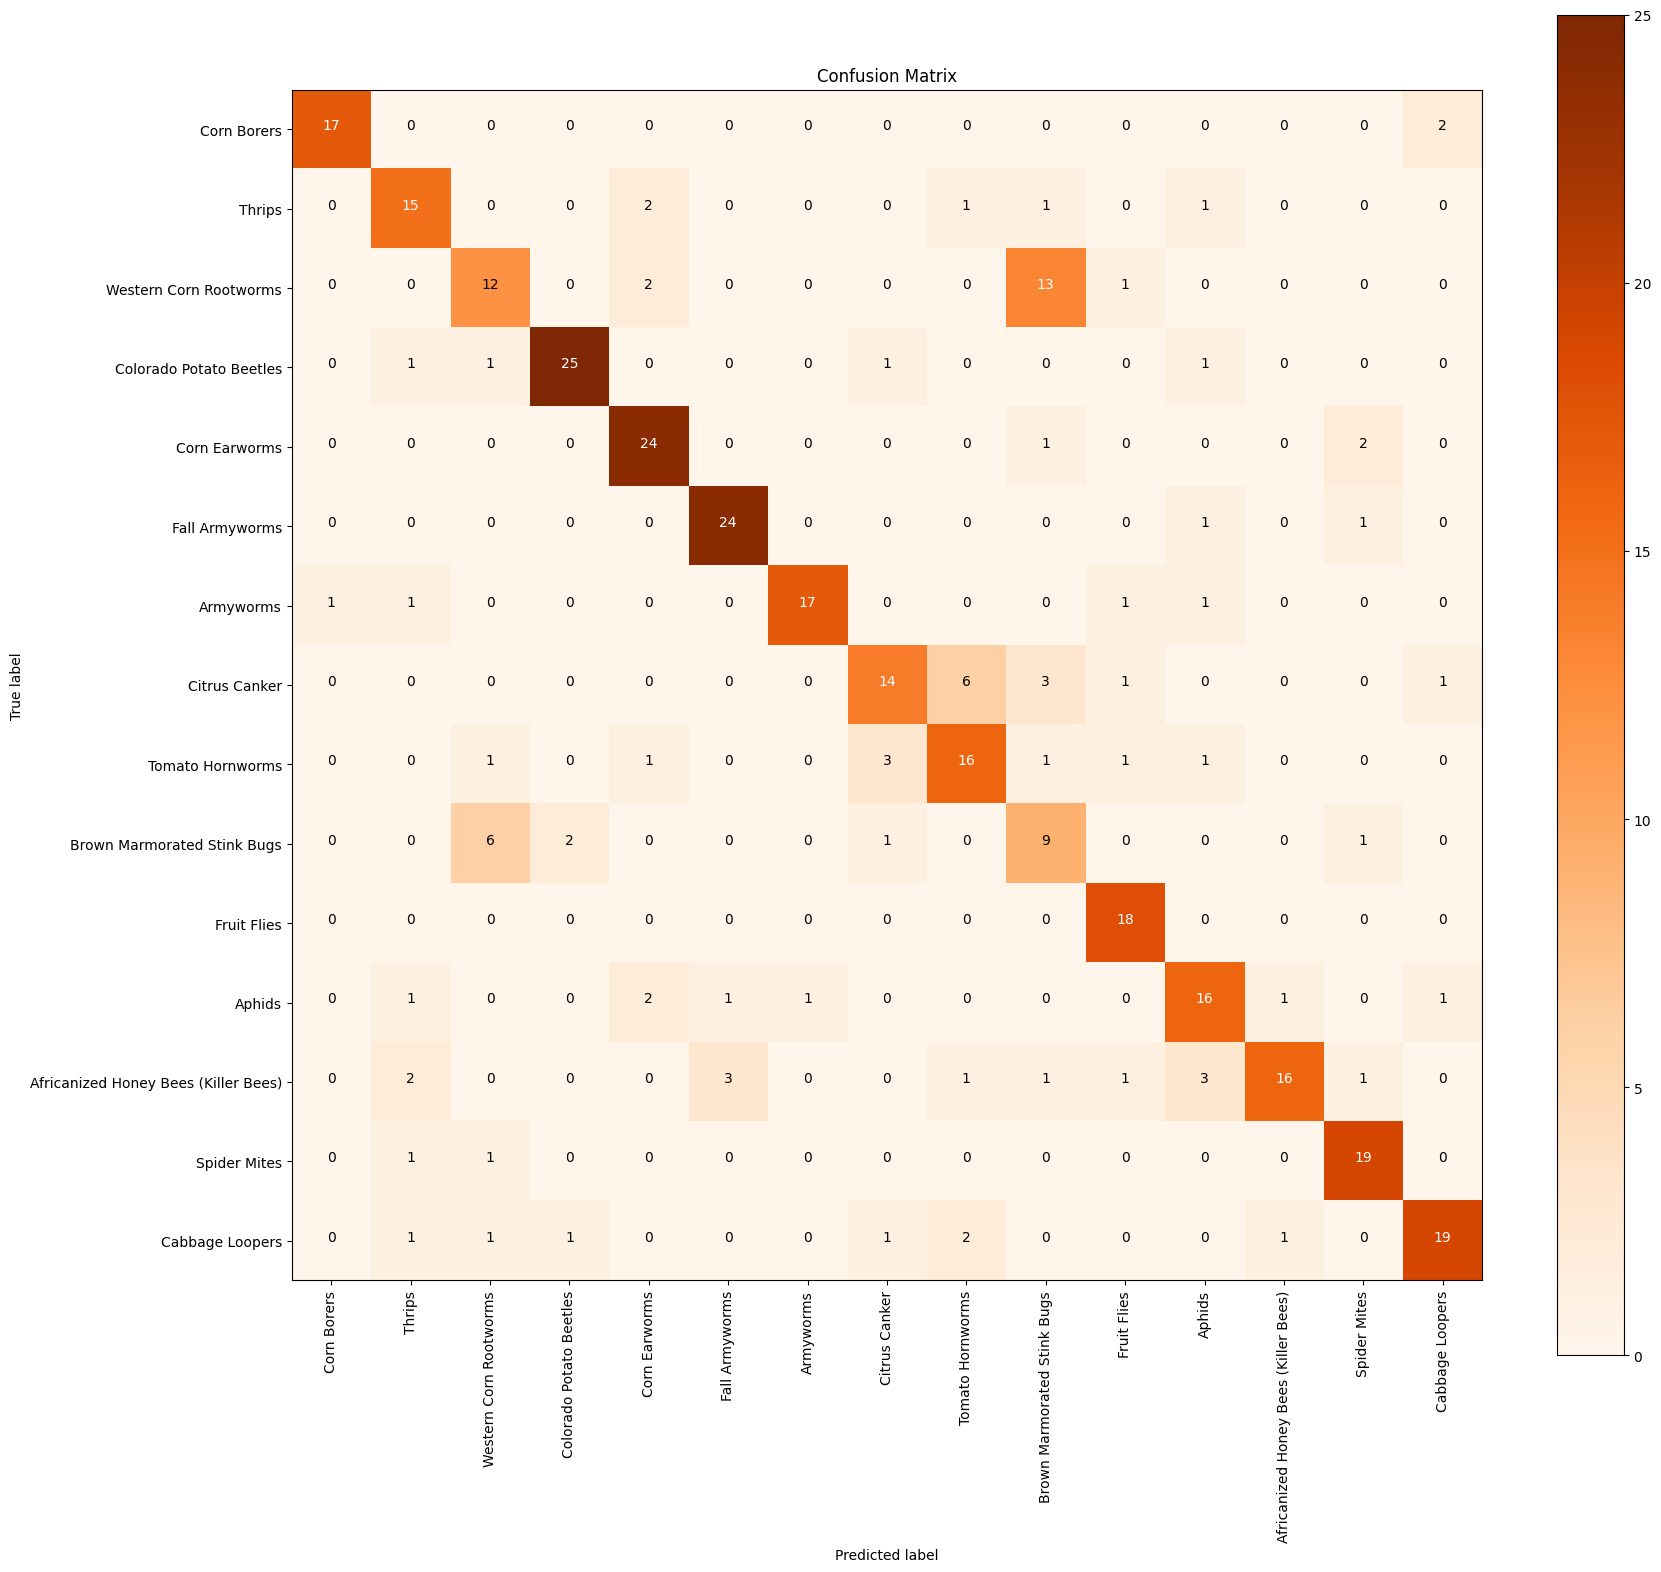


Classification report:
                                      precision    recall  f1-score   support

                         Corn Borers     0.9444    0.8947    0.9189        19
                              Thrips     0.6818    0.7500    0.7143        20
              Western Corn Rootworms     0.5455    0.4286    0.4800        28
             Colorado Potato Beetles     0.8929    0.8621    0.8772        29
                       Corn Earworms     0.7742    0.8889    0.8276        27
                      Fall Armyworms     0.8571    0.9231    0.8889        26
                           Armyworms     0.9444    0.8095    0.8718        21
                       Citrus Canker     0.7000    0.5600    0.6222        25
                    Tomato Hornworms     0.6154    0.6667    0.6400        24
         Brown Marmorated Stink Bugs     0.3103    0.4737    0.3750        19
                         Fruit Flies     0.7826    1.0000    0.8780        18
                              Aphids   

In [55]:
evaluate_model(mobilenet_model, test_generator, labels_list)

#### ResNet

12/12 [==============================] - 6s 406ms/step
Accuracy: 0.1780
F1 Score: 0.1258


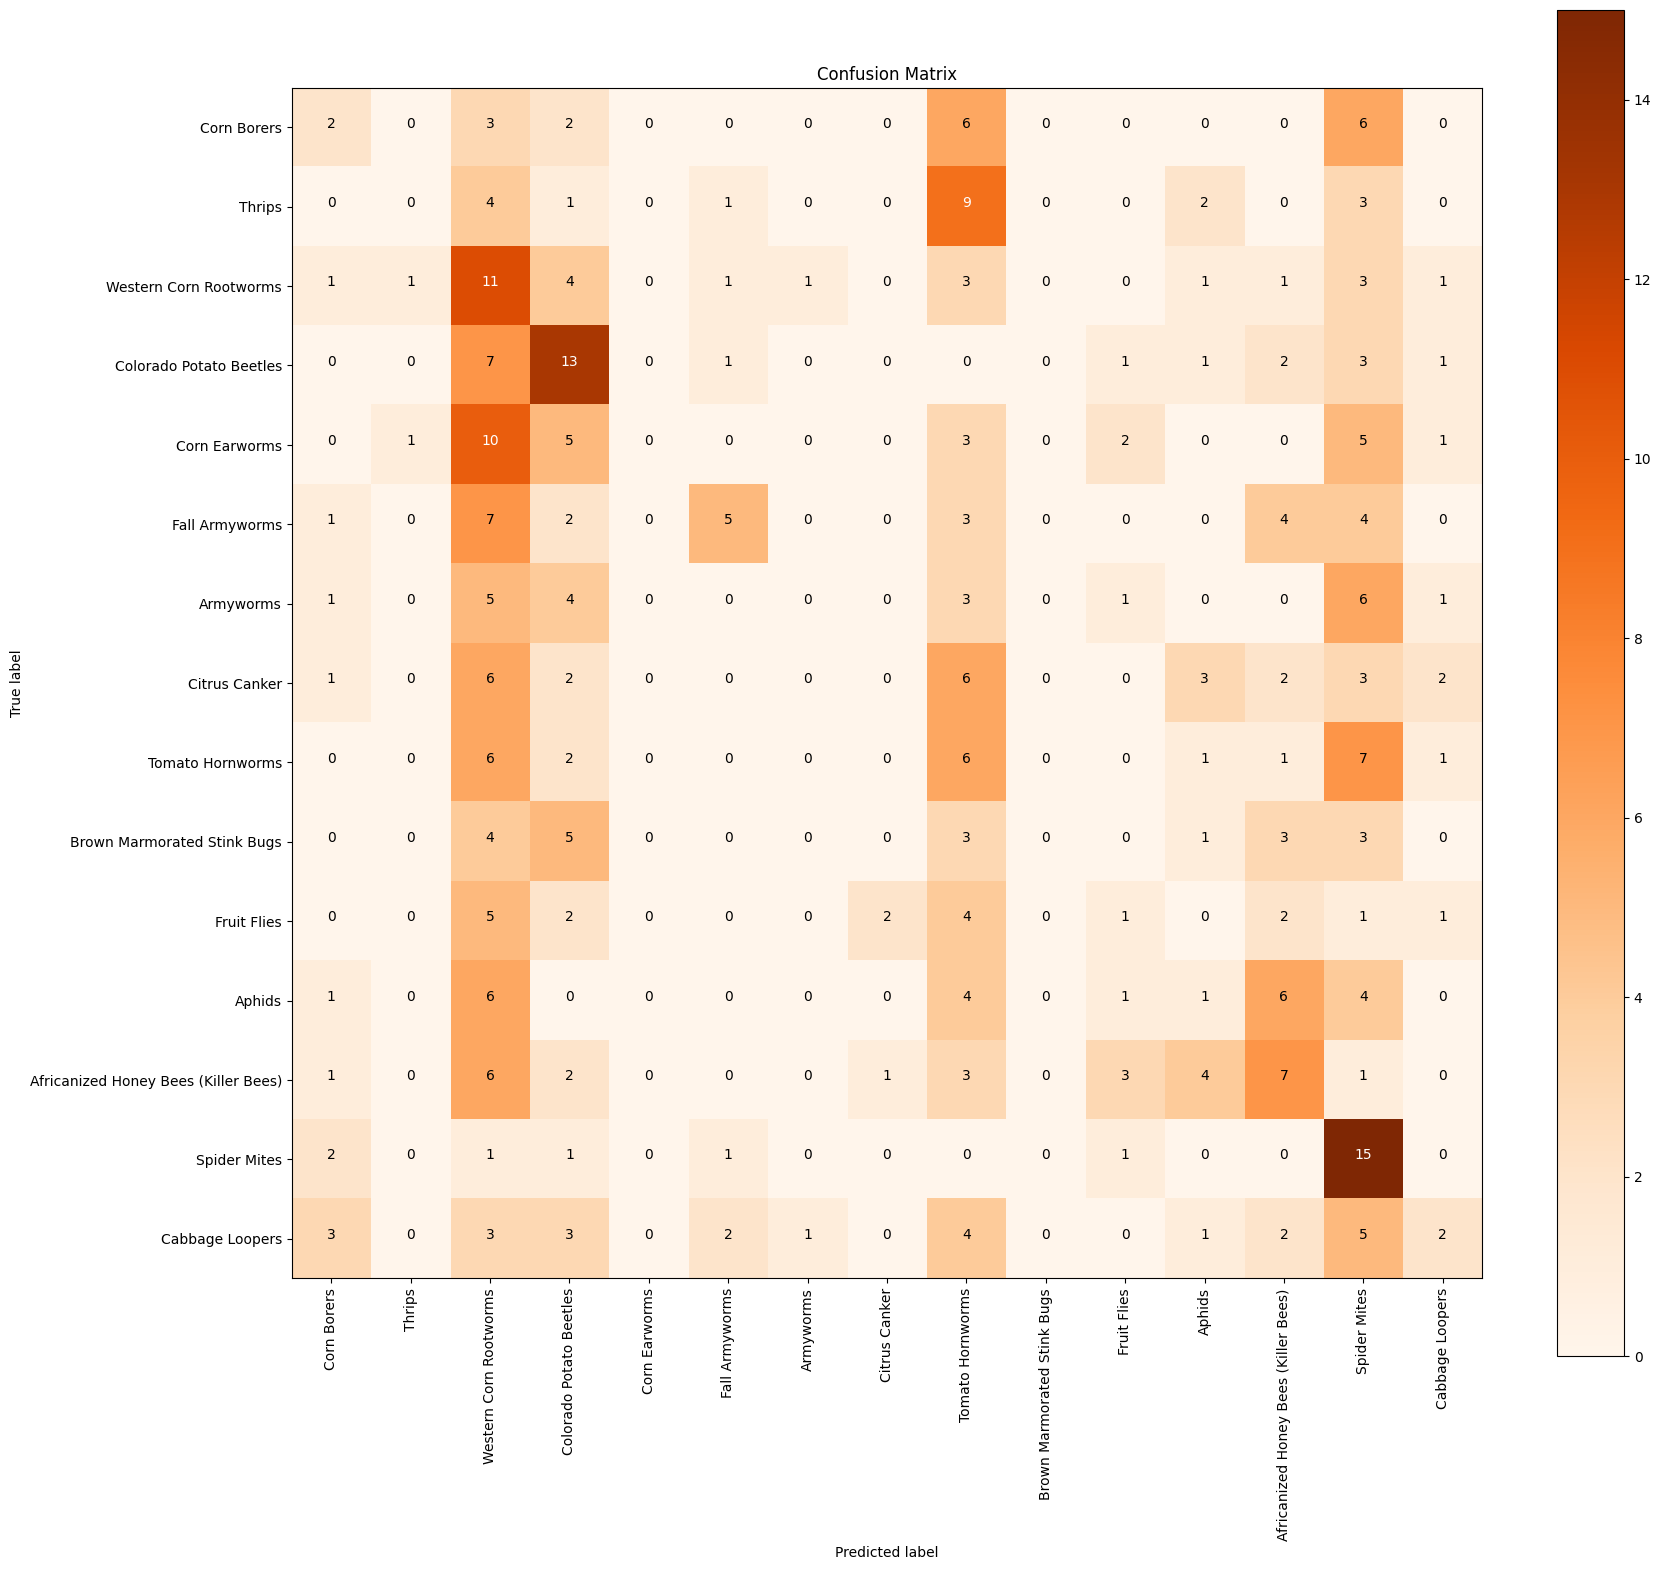


Classification report:
                                      precision    recall  f1-score   support

                         Corn Borers     0.1538    0.1053    0.1250        19
                              Thrips     0.0000    0.0000    0.0000        20
              Western Corn Rootworms     0.1310    0.3929    0.1964        28
             Colorado Potato Beetles     0.2708    0.4483    0.3377        29
                       Corn Earworms     0.0000    0.0000    0.0000        27
                      Fall Armyworms     0.4545    0.1923    0.2703        26
                           Armyworms     0.0000    0.0000    0.0000        21
                       Citrus Canker     0.0000    0.0000    0.0000        25
                    Tomato Hornworms     0.1053    0.2500    0.1481        24
         Brown Marmorated Stink Bugs     0.0000    0.0000    0.0000        19
                         Fruit Flies     0.1000    0.0556    0.0714        18
                              Aphids   

In [56]:
evaluate_model(resnet_model, test_generator, labels_list)

#### EffecientNet

12/12 [==============================] - 7s 407ms/step
Accuracy: 0.0734
F1 Score: 0.0091


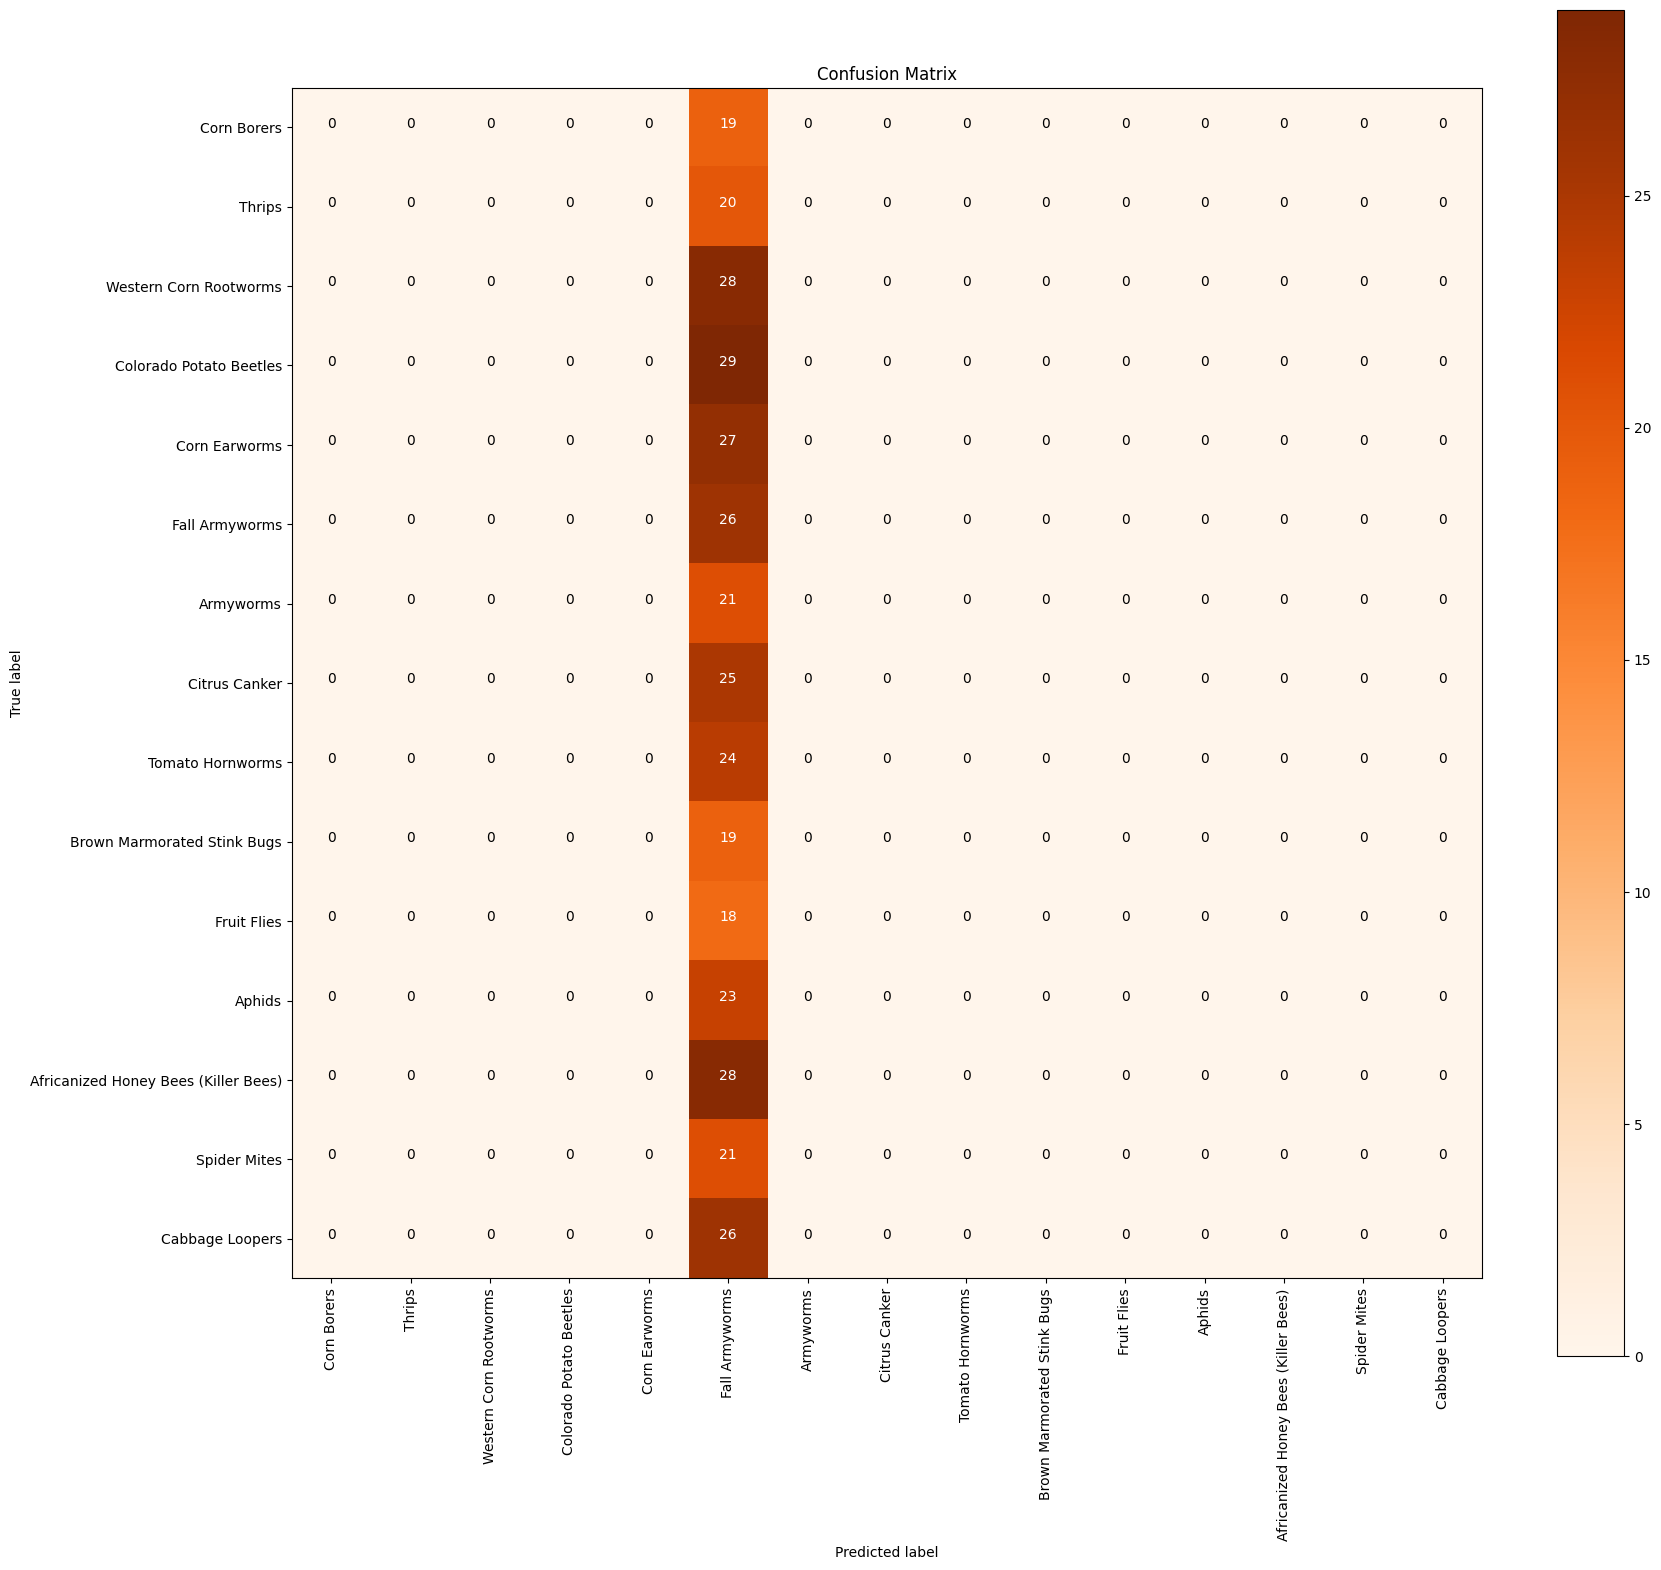


Classification report:
                                      precision    recall  f1-score   support

                         Corn Borers     0.0000    0.0000    0.0000        19
                              Thrips     0.0000    0.0000    0.0000        20
              Western Corn Rootworms     0.0000    0.0000    0.0000        28
             Colorado Potato Beetles     0.0000    0.0000    0.0000        29
                       Corn Earworms     0.0000    0.0000    0.0000        27
                      Fall Armyworms     0.0734    1.0000    0.1368        26
                           Armyworms     0.0000    0.0000    0.0000        21
                       Citrus Canker     0.0000    0.0000    0.0000        25
                    Tomato Hornworms     0.0000    0.0000    0.0000        24
         Brown Marmorated Stink Bugs     0.0000    0.0000    0.0000        19
                         Fruit Flies     0.0000    0.0000    0.0000        18
                              Aphids   

In [57]:
evaluate_model(efficientnet_model, test_generator, labels_list)

#### Xception

12/12 [==============================] - 6s 411ms/step
Accuracy: 0.7542
F1 Score: 0.7539


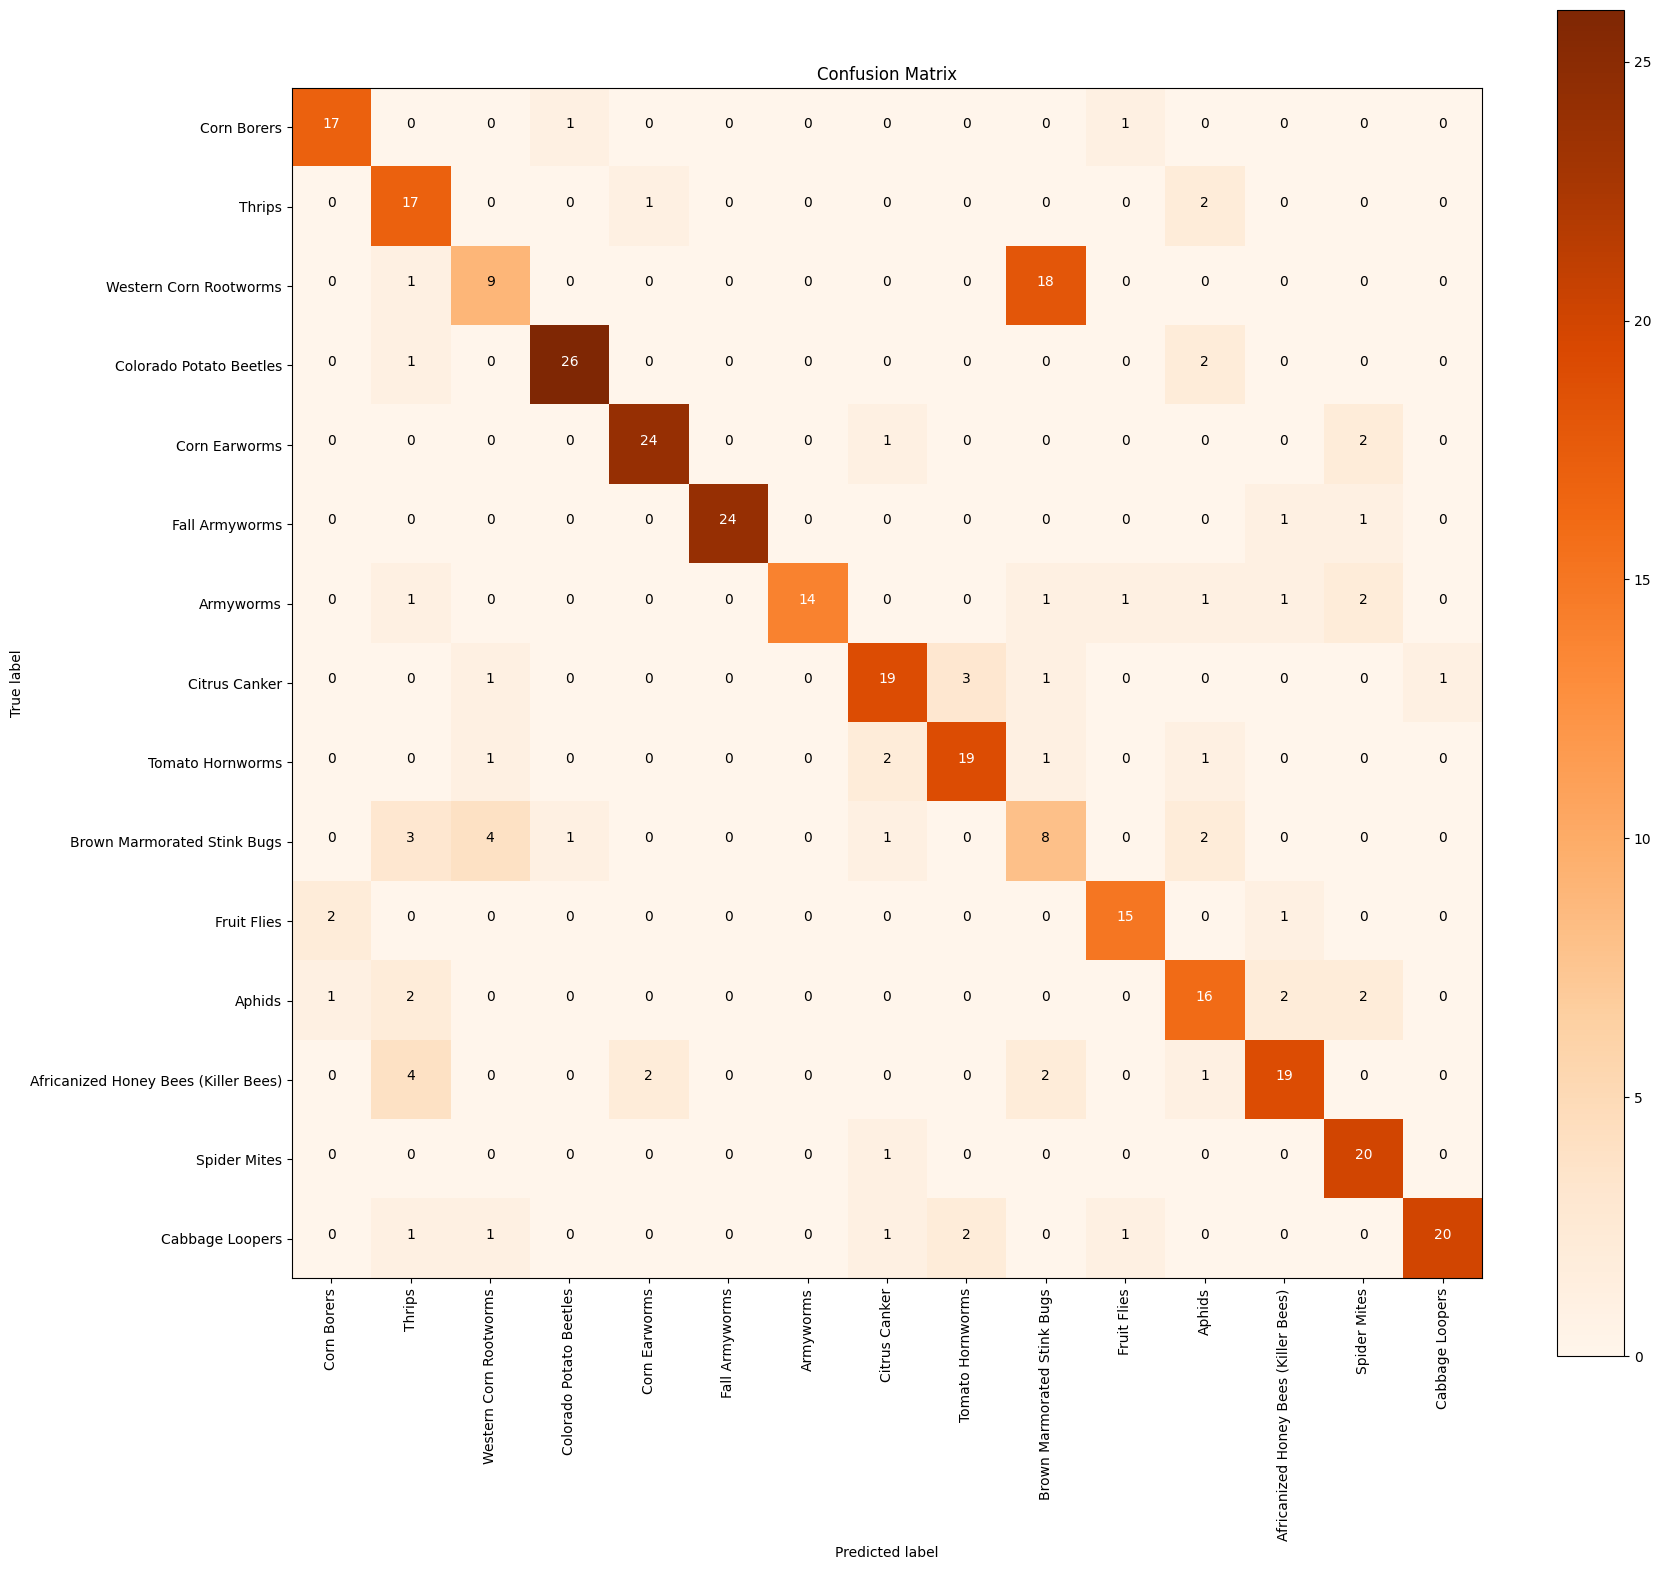


Classification report:
                                      precision    recall  f1-score   support

                         Corn Borers     0.8500    0.8947    0.8718        19
                              Thrips     0.5667    0.8500    0.6800        20
              Western Corn Rootworms     0.5625    0.3214    0.4091        28
             Colorado Potato Beetles     0.9286    0.8966    0.9123        29
                       Corn Earworms     0.8889    0.8889    0.8889        27
                      Fall Armyworms     1.0000    0.9231    0.9600        26
                           Armyworms     1.0000    0.6667    0.8000        21
                       Citrus Canker     0.7600    0.7600    0.7600        25
                    Tomato Hornworms     0.7917    0.7917    0.7917        24
         Brown Marmorated Stink Bugs     0.2581    0.4211    0.3200        19
                         Fruit Flies     0.8333    0.8333    0.8333        18
                              Aphids   

In [58]:
evaluate_model(xception_model, test_generator, labels_list)

### Comparaison entre les modèles

On itére sur les modèles

In [59]:
models = [resnet_model, mobilenet_model, efficientnet_model, xception_model]
model_names = ['ResNet', 'MobileNet', 'EfficientNet', 'Xception']
generators = [test_generator , test_generator , test_generator , test_generator ]
results = []
for model, model_name, test_generator in zip(models, model_names, generators):
    predictions = model.predict(test_generator)
    # Convertir les prédictions en classes prédites
    y_true = test_generator.classes
    y_pred = predictions.argmax(axis=1)
    # Calculer les scores
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    # Stocker les résultats dans la liste
    results.append({'Model': model_name, 'Accuracy': accuracy, 'F1-Score': f1, 'Recall': recall})
results.append({'Model': 'ViT', 'Accuracy': accuracy_vit, 'F1-Score': f1_vit, 'Recall': recall_vit})

12/12 [==============================] - 6s 450ms/step


Afficher la DataFrame

In [60]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-Score,Recall
0,ResNet,0.177966,0.125826,0.168596
1,MobileNet,0.737288,0.739360,0.743989
2,EfficientNet,0.073446,0.009123,0.066667
3,Xception,0.754237,0.753926,0.756216
4,ViT,0.812325,0.801360,0.813406


La comparaison des modèles révèle des performances variées en termes d'exactitude, de f1-score et de rappel. Xception et ViT se distinguent comme les modèles les plus performants, avec des précisions respectives de 75,42 % et 81,23 %, reflétant également des f1-scores élevés (>75 %). MobileNet affiche une précision légèrement inférieure (73,73 %) mais reste compétitif. En revanche, ResNet (17,80 %) et EfficientNet (7,34 %) montrent des résultats significativement plus faibles, indiquant des difficultés à généraliser correctement. Ces résultats soulignent l'efficacité des architectures modernes comme ViT pour des tâches complexes de classification d'images.